### Load Data

Imported pandas and loaded the Solana memo messages CSV file. Displayed the first few rows to inspect the data.


In [83]:
import pandas as pd

file_path = r"C:\Users\aadit\Downloads\project\solana_memo_messages (1).csv"
df = pd.read_csv(file_path)
df.head()


,timestamp,sender_wallet,message
0,2024-06-17 11:41:00,01e7bc6097ca36668cd61dc9693dd5cc,bearish af
1,2024-06-10 05:47:00,1f704c573733cb6ff98a7cfc68a602b5,to the moon!
2,2024-06-13 23:15:00,ea35264cbdef6ff66a774d86f36bc26a,degen move
3,2024-06-16 04:58:00,ee1dcce08bb414d2e760b12f5670d508,moon soon
4,2024-06-10 00:24:00,e795a31b18c99cd64ea6f87cc5bfd2de,diamond hands


### Import Libraries

Imported necessary libraries for text processing and sentiment analysis (TextBlob, VADER). Downloaded the VADER lexicon for sentiment scoring.


In [85]:
import pandas as pd
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download necessary resource for VADER
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aadit\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Text Cleaning

Cleaned the memo messages by removing URLs, punctuation, numbers, and extra spaces. Added a new column `cleaned_message` for further sentiment analysis.


In [87]:
def clean_text(text):
    text = str(text).lower()  # lowercase
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove numbers, punctuation, emojis
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespace
    return text

# Apply it to a new column
df["cleaned_message"] = df["message"].apply(clean_text)
df[["message", "cleaned_message"]].head()


,message,cleaned_message
0,bearish af,bearish af
1,to the moon!,to the moon
2,degen move,degen move
3,moon soon,moon soon
4,diamond hands,diamond hands


### Sentiment Analysis

Performed sentiment analysis using TextBlob and VADER. Extracted polarity, subjectivity, and compound scores, and saved the results to `sentiment_output.csv`.


In [89]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.polarity, blob.subjectivity])

df[["textblob_polarity", "textblob_subjectivity"]] = df["cleaned_message"].apply(get_textblob_sentiment)

vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return pd.Series([scores["neg"], scores["neu"], scores["pos"], scores["compound"]])

df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]] = df["cleaned_message"].apply(get_vader_sentiment)

df.to_csv("sentiment_output.csv", index=False)
print("Sentiment scores saved to sentiment_output.csv")


Sentiment scores saved to sentiment_output.csv


### Daily Sentiment Aggregation

Converted timestamps to dates and grouped the data by day. Calculated daily averages for sentiment scores and counted the number of messages per day.


In [91]:
# Convert to datetime (if not already)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract date only (no time)
df['date'] = df['timestamp'].dt.date

daily_sentiment = df.groupby('date').agg({
    'textblob_polarity': 'mean',
    'textblob_subjectivity': 'mean',
    'vader_neg': 'mean',
    'vader_neu': 'mean',
    'vader_pos': 'mean',
    'vader_compound': 'mean',
    'message': 'count'  # optional: number of messages that day
}).reset_index()

daily_sentiment.rename(columns={'message': 'message_count'}, inplace=True)
daily_sentiment.head()


,date,textblob_polarity,textblob_subjectivity,vader_neg,vader_neu,vader_pos,vader_compound,message_count
0,2024-06-01,0.035714,0.035714,0.051571,0.948429,0.000000,-0.027271,14
1,2024-06-02,0.070000,0.110000,0.153400,0.776000,0.070600,-0.068120,10
2,2024-06-03,0.068939,0.186364,0.104591,0.873864,0.021545,-0.060432,22
3,2024-06-04,0.061111,0.072222,0.125333,0.835444,0.039222,-0.059056,18
4,2024-06-05,0.039744,0.215385,0.000000,0.963538,0.036462,0.015562,13


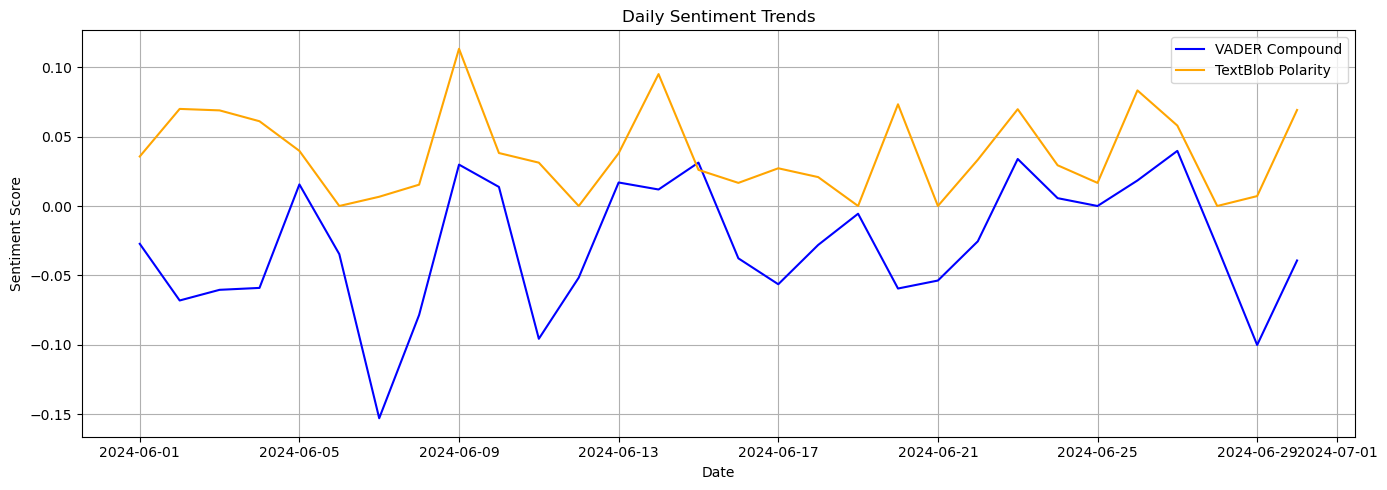

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(daily_sentiment['date'], daily_sentiment['vader_compound'], label='VADER Compound', color='blue')
plt.plot(daily_sentiment['date'], daily_sentiment['textblob_polarity'], label='TextBlob Polarity', color='orange')
plt.legend()
plt.title("Daily Sentiment Trends")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### Sentiment Data Check

Reloaded the sentiment CSV and converted timestamps. Printed the start and end dates and checked the column names for verification.


In [94]:
import pandas as pd

df_sentiment = pd.read_csv("sentiment_output.csv")
df_sentiment['timestamp'] = pd.to_datetime(df_sentiment['timestamp'])

print("Start date:", df_sentiment['timestamp'].min().date())
print("End date:", df_sentiment['timestamp'].max().date())

import pandas as pd

df_sentiment = pd.read_csv("sentiment_output.csv")
print(df_sentiment.columns.tolist())


Start date: 2024-06-01
End date: 2024-06-30
['timestamp', 'sender_wallet', 'message', 'cleaned_message', 'textblob_polarity', 'textblob_subjectivity', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']


### Merge Sentiment and Price Data

Merged daily sentiment scores with Solana price data on the `date` column and saved the combined dataset as `merged_sentiment_price.csv`.


In [96]:
import pandas as pd

# Load datasets
df_sentiment = pd.read_csv("sentiment_output.csv")
df_price = pd.read_csv("solana_price_june_2024.csv")

# Convert timestamps to just date (yyyy-mm-dd)
df_sentiment['date'] = pd.to_datetime(df_sentiment['timestamp']).dt.date
df_price['date'] = pd.to_datetime(df_price['date']).dt.date

# Merge on the 'date' column
df_merged = pd.merge(df_sentiment, df_price, on='date', how='inner')

# Save to a new CSV
df_merged.to_csv("merged_sentiment_price.csv", index=False)

print("✅ Merge complete. Rows:", len(df_merged))


✅ Merge complete. Rows: 500


In [97]:
# Optional: Add a target variable — e.g., price movement
df_merged['price_diff'] = df_merged['close'].diff()
df_merged['target'] = df_merged['price_diff'].apply(lambda x: 1 if x > 0 else 0)

# Optionally drop rows with NaN (from .diff())
df_merged.dropna(inplace=True)


### Train Random Forest Model

Selected sentiment and price features, split the data into training and testing sets, and trained a Random Forest Classifier. Evaluated the model using accuracy and confusion matrix, and visualized feature importance.


Accuracy: 0.68
Confusion Matrix:
 [[32 21]
 [11 36]]


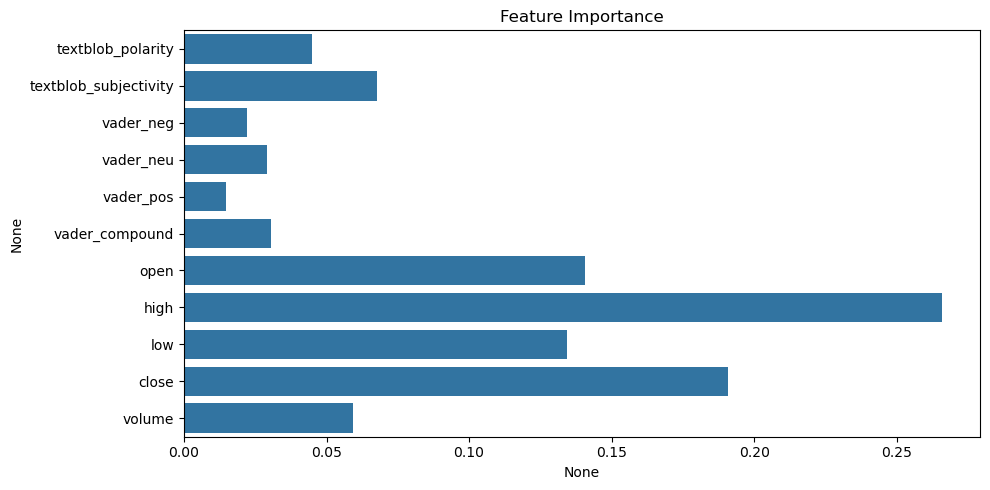

In [99]:
from sklearn.model_selection import train_test_split

# Select features (you can adjust these)
features = [
    'textblob_polarity', 'textblob_subjectivity',
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'open', 'high', 'low', 'close', 'volume'
]
X = df_merged[features]
y = df_merged['target']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict & Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(model.feature_importances_, index=features)
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()



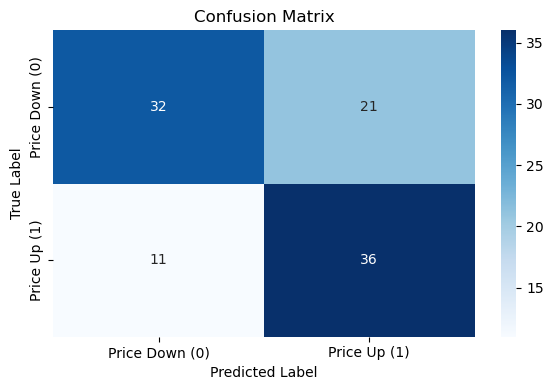

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Actual values and predictions (assuming these are already available)
# y_test and y_pred

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Price Down (0)', 'Price Up (1)']

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [101]:
from sklearn.metrics import f1_score, roc_auc_score

# Already predicted labels
y_pred = model.predict(X_test)

# Predict probability that price will go up (class 1)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)


F1 Score: 0.6923076923076923
ROC-AUC Score: 0.7573263749498194


### Compare Multiple Models

Trained and evaluated Logistic Regression, SVM, and XGBoost models. Calculated accuracy, F1 score, and ROC-AUC score for each, and displayed the results in a comparison table.


In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # needed for ROC-AUC
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    results[name] = {
        'Accuracy': acc,
        'F1 Score': f1,
        'ROC-AUC': roc
    }

# Show results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


                     Accuracy  F1 Score   ROC-AUC
Logistic Regression      0.60  0.607843  0.638097
SVM                      0.60  0.636364  0.594942
XGBoost                  0.69  0.699029  0.750903


C:\Users\aadit\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:12:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 Confusion Matrix - Logistic Regression
[[29 24]
 [16 31]]


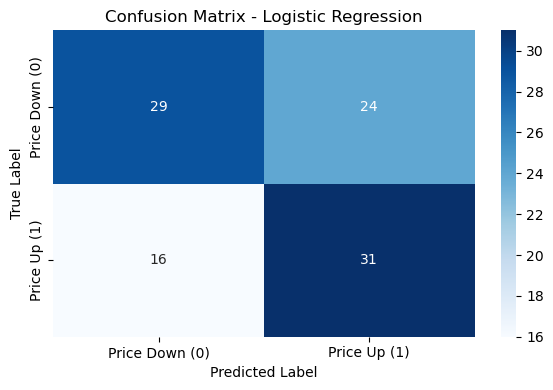


📊 Confusion Matrix - SVM
[[25 28]
 [12 35]]


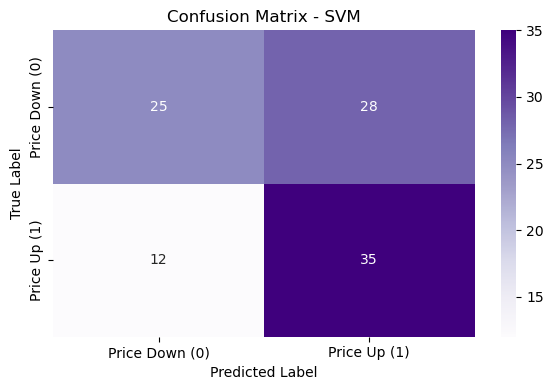


📊 Confusion Matrix - XGBoost
[[33 20]
 [11 36]]


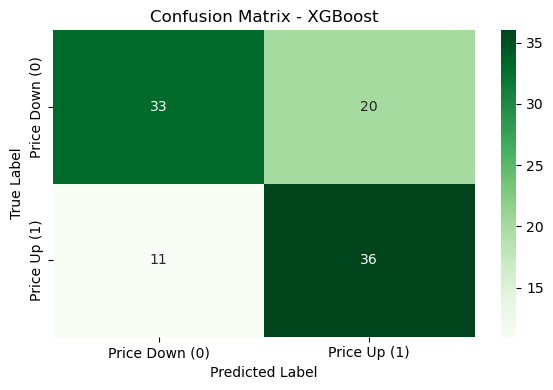

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['Price Down (0)', 'Price Up (1)']

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
cm_log = confusion_matrix(y_test, y_pred_log)
print("📊 Confusion Matrix - Logistic Regression")
print(cm_log)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("\n📊 Confusion Matrix - SVM")
print(cm_svm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\n📊 Confusion Matrix - XGBoost")
print(cm_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


C:\Users\aadit\AppData\Local\Temp\ipykernel_14016\2807816927.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')


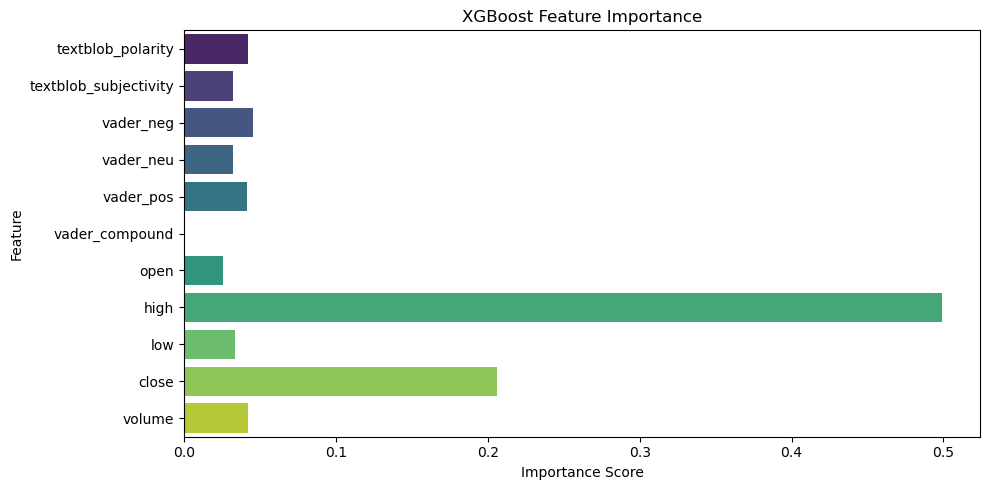

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you still have your feature list
features = [
    'textblob_polarity', 'textblob_subjectivity',
    'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
    'open', 'high', 'low', 'close', 'volume'
]

# Get importances
xgb_importances = pd.Series(xgb_model.feature_importances_, index=features)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index, palette='viridis')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
